# 50/60 Hz noise attenuation

Attenuation of industrial noise in seismic traces.

* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Runnig time](#Running-time)
* [Model evaluation](#Model-evaluation)
* [Criticism](#Criticism)
* [Conclusion](#Conclusion)
* [Suggestions for improvements](#Suggestions-for-improvements)

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from functools import partial
import shutil

sys.path.append('../..')

from seismicpro.batchflow import Dataset, DatasetIndex, Pipeline, V, B, L, I, W, P, R, D, action
from seismicpro.batchflow.models.torch import UNet

from seismicpro.src import (SeismicBatch, SeismicDataset, FieldIndex, TraceIndex, statistics_plot,
                            seismic_plot, spectrum_plot, merge_segy_files, traces_plot, plot_loss)
from seismicpro.models import FieldMetrics

%env CUDA_VISIBLE_DEVICES=7

env: CUDA_VISIBLE_DEVICES=7


## Dataset

Here we are using a dataset with equalized amplitude values. Equalization is necessary because dataset contains data from several surveys, so absolute values of amplitude may vary. We make sure that for each survey 95% of the data lie within [-1, 1] interval. [Here](https://github.com/gazprom-neft/SeismicPro/models/Industry_noise/) you can find the code for equalization procedure.

In [2]:
path_lift = '../../../data/PREP/0825_50Hz_45Hz_fnum/4_PREP_output_50Hz_45Hz_fnum_0825_eq.sgy'

index_train = (FieldIndex(name='lift', 
                    extra_headers=['offset', 'YearDataRecorded'],
                    path=path_lift))

index_train.head()

,TraceNumber,YearDataRecorded,offset,TRACE_SEQUENCE_FILE,file_id
,,,,lift,lift
FieldRecord,,,,,
13006720,1,99,2579,1,../../../data/PREP/0825_50Hz_45Hz_fnum/4_PREP_...
13006720,2,99,2530,2,../../../data/PREP/0825_50Hz_45Hz_fnum/4_PREP_...
13006720,3,99,2482,3,../../../data/PREP/0825_50Hz_45Hz_fnum/4_PREP_...
13006720,4,99,2433,4,../../../data/PREP/0825_50Hz_45Hz_fnum/4_PREP_...
13006720,5,99,2385,5,../../../data/PREP/0825_50Hz_45Hz_fnum/4_PREP_...


Train set consists of the clean data. We will generate noise on the go and add it to clean signals:

In [4]:
train = SeismicDataset(TraceIndex(index_train))

## Model architecture

We use UNet model with four blocks of downsampling / upsampling. Here is the definition of model config and loss function:

In [5]:
inputs_config = {
    'raw/shape': (1, 2001), 
    'targets/shape': (1, 2001)
    }

model_config = {
    'initial_block/inputs': 'raw',
    'inputs': inputs_config,
    'loss': 'l1',
    'optimizer': 'Adam',
    'body/filters': [32, 64, 128, 256],
    'body/num_blocks': 4,
    'body/encoder': {'layout':'cnanca', 'kernel_size':7},
    'body/decoder': {'layout':'cnanca', 'kernel_size':7},
    'body/upsample': {'layout':'ta', 'kernel_size':7},
    'device': 'gpu:0',
}

## Data processing

There are few traces with industrial noise in the data. So we will generate industrial-like noise with this function and add it to the clean traces:

In [7]:
def add_noise(sig, freq, scale, shift, amp_freqs, amp_scale, freq_freqs, freq_scale, sr=500, length=None):
    
    trace_length = sig.shape[1] if sig.ndim == 2 else sig.shape[0]
    length = length or (trace_length - 1) / sr
    t = np.linspace(0, length, sr * length + 1)

    # dynamic amplitute
    amp = np.sum([np.sin(f * 2 * np.pi * t) for f in amp_freqs], axis=0)
    scale = scale + amp * (amp_scale / np.max(np.abs(amp)))

    #dynamic frequency
    fr = np.sum([np.sin(f * 2 * np.pi * t) for f in freq_freqs], axis=0)
    freq = freq + fr * (freq_scale / np.max(np.abs(fr)))

    # combine altogether
    max_amp = np.max(np.abs(sig))
    scale = scale * max_amp
    noise = scale * np.sin((freq * 2 * np.pi * t) + shift)
    return sig + noise

## Training

In [6]:
BATCH_SIZE = 512
N_EPOCHS = 500

Training pipeline actions:
* loading a batch of raw and target traces
* model weights update

Optimizer configuration:
* optimizer: Adam
* learning_rate = 0.001

Training scheme:
* ```batch_size``` = 512
* ```n_epochs``` = 500

Here are the parameters for noise generation function:

In [8]:
freq = P(R('randint', 50 - 10 * I('r'), 51 + 10 * I('r')))
shift = P(R('uniform', 0, np.pi))
scale = P(R('uniform', 0.2, 1 + I('r') * 2))

amp_scale = P(R('normal', 0.1 * I('r'), 0.02))
amp_freqs = P(R('uniform', 1, 1 + I('r'), size=3))

freq_scale = P(R('normal', 0.2 * I('r'), 0.05))
freq_freqs = P(R('uniform', 1, 1 + I('r'), size=3))

Define a train pipeline:

In [9]:
train_pipeline = (train.pipeline()
                  .init_model('dynamic', UNet, name='unet', config=model_config)
                  .init_variable('loss', default=list())
                  .load(components=('lift'), fmt='segy')
                  .apply_transform(lambda x: np.zeros_like(x), src='lift', dst='lift', p=0.05)
                  .apply_transform(lambda *args: add_noise(*args), freq, shift, scale, amp_freqs, amp_scale, freq_freqs, freq_scale,
                                   src='lift', dst='raw', p=1)
                  .apply_transform_all(src=['raw', 'lift'], dst=['raw', 'lift'], func=lambda x: np.stack(x).astype(np.float32))
                  .train_model('unet', B.raw, B.lift, fetches=['loss'], save_to=[V('loss', 'a')])
                  .run_later(batch_size=BATCH_SIZE, n_epochs=N_EPOCHS, shuffle=True, drop_last=True, bar=True)
                 )

Run model training:

In [ ]:
train_pipeline.run()

 85%|████████▍ | 16107/19000 [8:43:22<1:38:12,  2.04s/it]

Plot loss function decay:

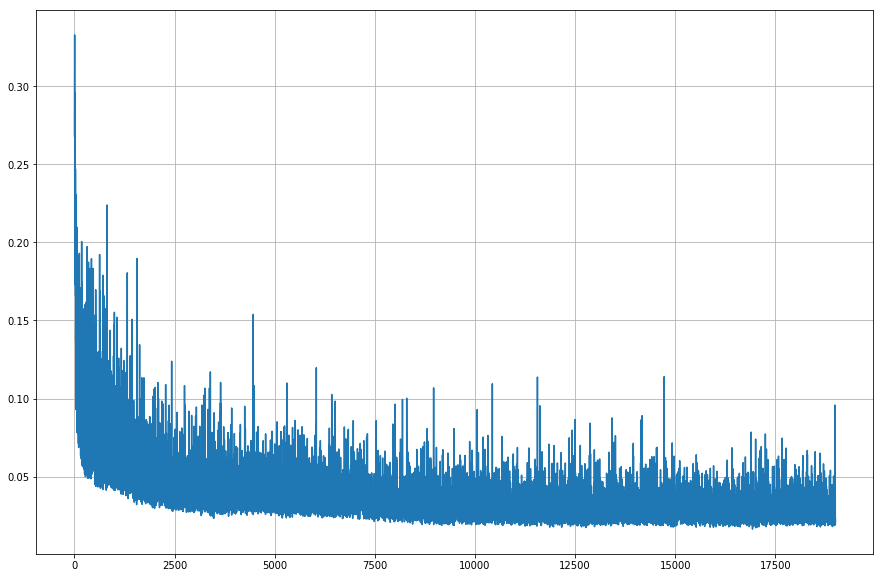

In [13]:
loss = train_pipeline.get_variable('loss')
plot_loss(loss)

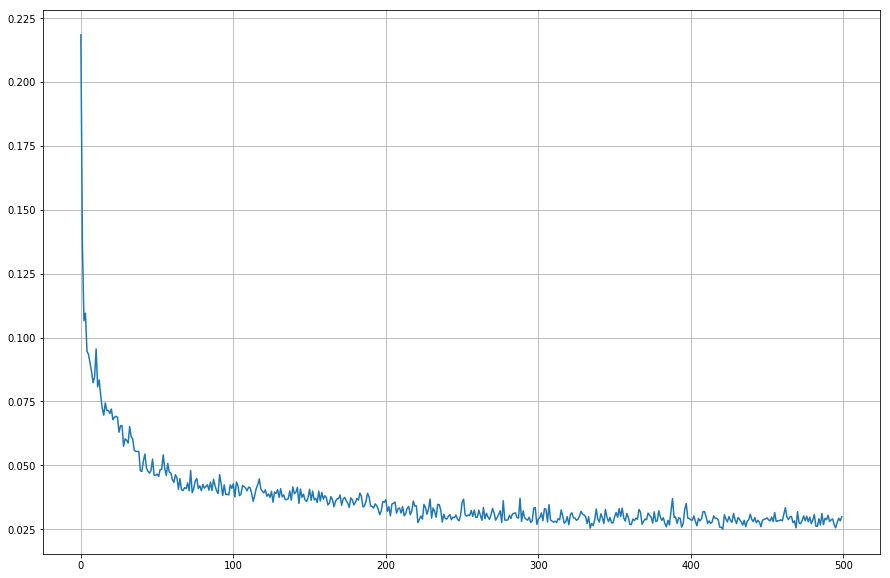

In [14]:
plot_loss(loss, plot_epochs=False, plot_epochs=True)

In [15]:
train_pipeline.save_model_now('unet', './unet_50_60_additive_500')

## Validation

Now we can test the model on the simulated data:

In [16]:
freq = P(R('randint', 40, 61))
shift = P(R('uniform', 0, np.pi))
scale = P(R('uniform', 0.2, 11))

amp_scale = P(R('normal', 0.1, 0.02))
amp_freqs = P(R('uniform', 1, 2, size=3))

freq_scale = P(R('normal', 0.2, 0.05))
freq_freqs = P(R('uniform', 1, 2, size=3))

load_config = {
    "build": False,
    'device': 'gpu:0',
    "load": {"path": './unet_50_60_additive_500'},
}

val_pipeline = (train.pipeline()
                  .init_model("static", UNet, 'unet', config=load_config)
                  .init_variable('loss', default=list())
                  .init_variable('raw')  
                  .init_variable('predictions')
                  .init_variable('targets')
                  .load(components=('lift'), fmt='segy')
                  .apply_transform(lambda *args: add_noise(*args), freq, shift, scale, amp_freqs, amp_scale, freq_freqs, freq_scale,
                                   src='lift', dst='raw', p=1.0)
                  .apply_transform_all(src='raw', dst='raw', func=lambda x: np.stack(x).astype(np.float32))
                  .apply_transform_all(src='lift', dst='lift', func=lambda x: np.stack(x).astype(np.float32))
                  .update(V('targets', 'w'), B('lift'))
                  .update(V('raw', 'w'), B('raw'))
                  .predict_model('unet', B.raw, fetches=['predictions'],
                               save_to=[V('predictions', 'w')]
                              )
                  .run_later()
                 )

In [17]:
batch = val_pipeline.next_batch(BATCH_SIZE)
raw, target, predict= [val_pipeline.get_variable(var) for var in ['raw', 'targets', 'predictions']]

../../seismicpro/batchflow/batchflow/batch.py:297: UserWarning: All batch data is erased
  warnings.warn("All batch data is erased")


Here is a plot of synthetically noised signal, model prediction and target signal. One can see that model removes noise quite well, but scales output signal:

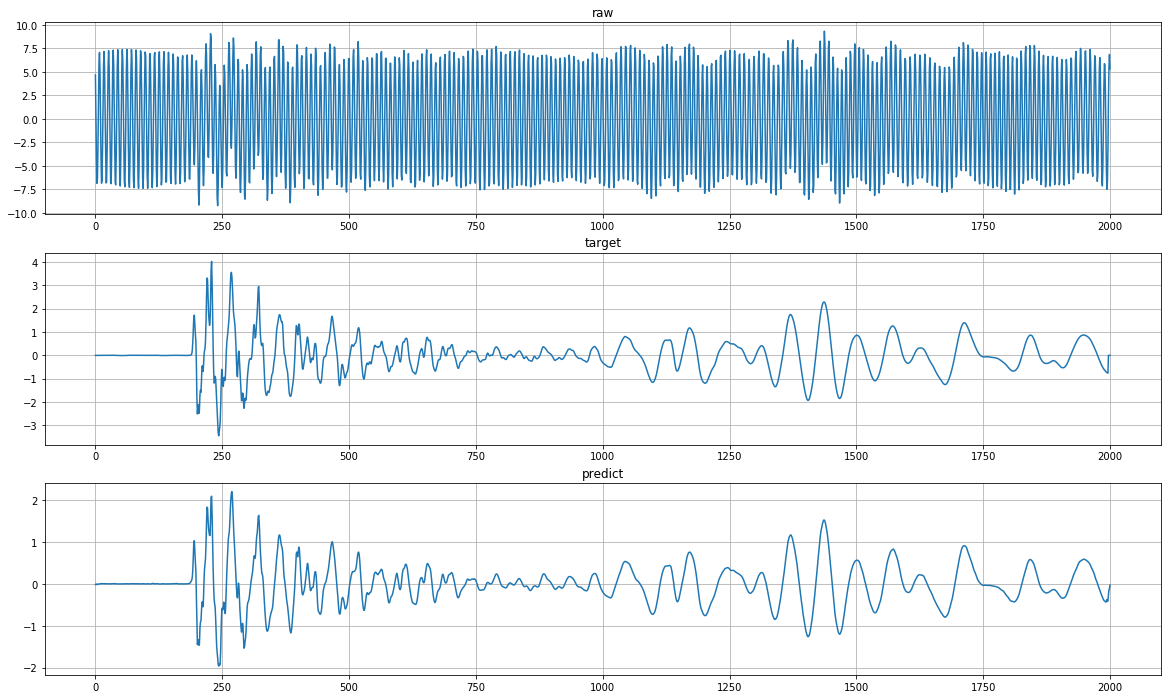

In [18]:
i = np.random.randint(len(batch))
data = raw[i], target[i], predict[i]
traces_plot(*data)

## Inference

Let's load data for inference, so that we can check model performance on real data from another region:

In [20]:
path_raw = '../../../data/PREP/0815_50Hz/6_input_50h_eq.sgy'
path_lift = '../../../data/PREP/0815_50Hz/6_output_50h_eq.sgy'

index_test = (FieldIndex(name='lift', 
                    extra_headers=['offset', 'YearDataRecorded'],
                    path=path_lift).merge(
               FieldIndex(name='raw', 
                    extra_headers=['offset', 'YearDataRecorded'],
                    path=path_raw)).merge(
               FieldIndex(name='preds', 
                    extra_headers=['offset', 'YearDataRecorded'],
                    path=path_raw)))

index_test.head()

,TraceNumber,YearDataRecorded,offset,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,,lift,lift,raw,raw,preds,preds
FieldRecord,,,,,,,,,
13006720,1,99,-2579,1,../../../data/PREP/0815_50Hz/6_output_50h_eq.sgy,1,../../../data/PREP/0815_50Hz/6_input_50h_eq.sgy,1,../../../data/PREP/0815_50Hz/6_input_50h_eq.sgy
13006720,2,99,-2530,2,../../../data/PREP/0815_50Hz/6_output_50h_eq.sgy,2,../../../data/PREP/0815_50Hz/6_input_50h_eq.sgy,2,../../../data/PREP/0815_50Hz/6_input_50h_eq.sgy
13006720,3,99,-2482,3,../../../data/PREP/0815_50Hz/6_output_50h_eq.sgy,3,../../../data/PREP/0815_50Hz/6_input_50h_eq.sgy,3,../../../data/PREP/0815_50Hz/6_input_50h_eq.sgy
13006720,4,99,-2433,4,../../../data/PREP/0815_50Hz/6_output_50h_eq.sgy,4,../../../data/PREP/0815_50Hz/6_input_50h_eq.sgy,4,../../../data/PREP/0815_50Hz/6_input_50h_eq.sgy
13006720,5,99,-2385,5,../../../data/PREP/0815_50Hz/6_output_50h_eq.sgy,5,../../../data/PREP/0815_50Hz/6_input_50h_eq.sgy,5,../../../data/PREP/0815_50Hz/6_input_50h_eq.sgy


In [21]:
test = SeismicDataset(TraceIndex(index_test))

Here is some data visualisation:

In [22]:
source_batch = (SeismicDataset(index_test).next_batch(1)
     .load(components=('raw','lift'), fmt='segy')
     .sort_traces(src=('raw', 'lift'), dst=('raw', 'lift'), sort_by='offset'))

Picture below shows power spectra in the selected window for data before and after manual processing. Seismogram with industrial noise has a spike in power spectra at about 50 Hz:

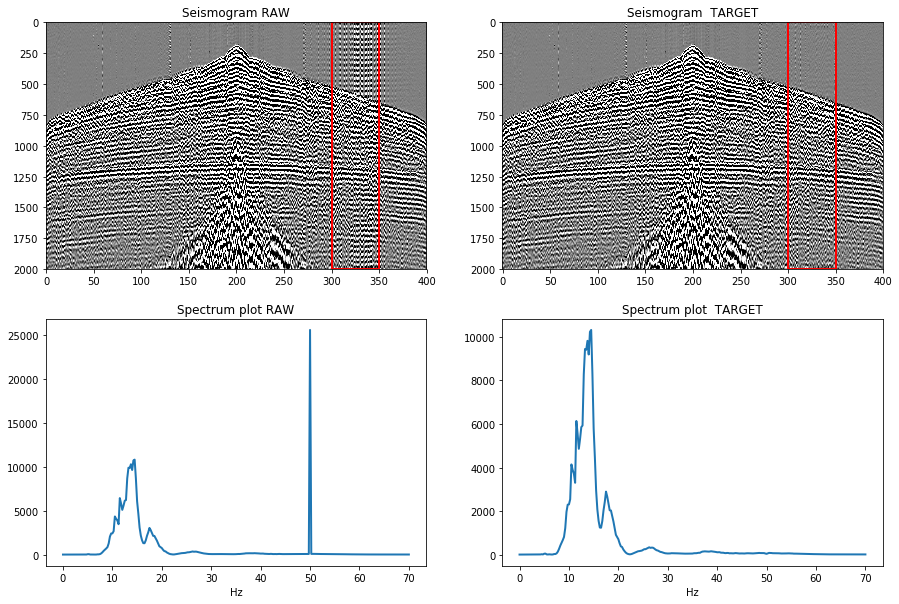

In [23]:
spectrum_plot([source_batch.raw[0], source_batch.lift[0]], frame=(slice(300, 350), slice(0, 2000)), rate=0.002, max_freq=70,
              figsize=(15, 10), vmin=-0.1, vmax=0.1, cmap='gray', names=['RAW', ' TARGET'])

Picture below shows an area of seismogram with noised traces:

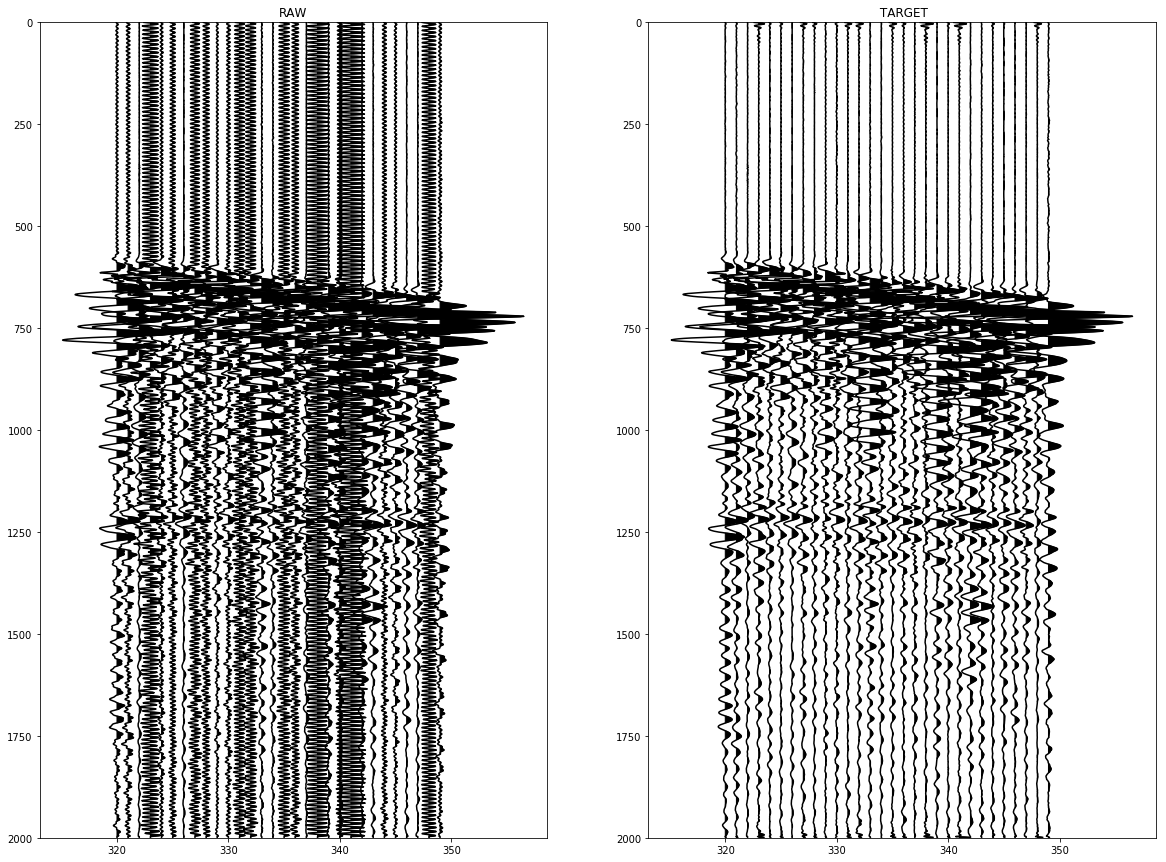

In [24]:
seismic_plot([source_batch.raw[0], source_batch.lift[0]], wiggle=True, xlim=(320, 350), ylim=(0, 2000),
              figsize=(20, 15), vmin=-0.1, vmax=0.1, cmap='gray', names=['RAW', ' TARGET'])

Inference pipeline. Note that one should specify temporary folder where processed batches will be stored before final merge, and path for the resulting merged file.

In [25]:
tmp_dump_path = '../../../data/PREP/tmp'
output_path = '../../../data/PREP/processed/pred.sgy'

load_config = {
    "build": False,
    'device': 'gpu:0',
    "load": {"path": './unet_50_60_additive_500'},
}

inference_ppl = (test.pipeline()
                 .init_model('dynamic', UNet, 'unet', config=load_config)
                 .load(components=('raw', 'lift', 'preds'), fmt='segy')
                 .apply_transform_all(src='raw', dst='raw', func=lambda x: np.stack(x).astype(np.float32))
                 .apply_transform_all(src='lift', dst='lift', func=lambda x: np.stack(x).astype(np.float32))
                 .predict_model('unet', B.raw, fetches=['predictions'], save_to=B('preds'))
                 .dump(path=L(lambda x: os.path.join(tmp_dump_path, str(x) + 'p.sgy'))(I()),
                       src='preds', fmt='segy', split=False)
                 .run_later(batch_size=600, n_epochs=1, drop_last=False, shuffle=False, bar=True)
                )

inference_ppl.after.merge_segy_files(output_path=output_path, extra_headers='all',
                                     path=os.path.join(tmp_dump_path, '*p.sgy'))

Run inference:

In [26]:
inference_ppl.run()

## Model evaluation

Since the model tends to scale output, we will rescale it with equalization:

In [27]:
# Clean the tmp directory
if os.path.exists(tmp_dump_path):
       shutil.rmtree(tmp_dump_path)

# Generate index for sgy file
index_train = (FieldIndex(name='tmp', 
                extra_headers='all',
                path=output_path))

# Create dataset of shot gathers
eq_datset = SeismicDataset(index_train)

# Run pipeline to calculate equalization parameters
preproc_pipeline = (
    eq_datset.pipeline()
        .load(fmt='sgy', components='tmp')
        .find_equalization_params(B(), component='tmp', survey_id_col='YearDataRecorded', container_name='equal_params')
        .run(batch_size=8, n_epochs=1, shuffle=False, drop_last=False, bar=True))

# Run pipeline to apply equalization and save resulting data
eq_pipeline = (
    eq_datset.pipeline()
        .load(fmt='sgy', components='tmp')
        .equalize(src='tmp', dst='tmp', params=D('equal_params'))
        .dump(path=L(lambda x: os.path.join(tmp_dump_path, str(x) + '.sgy'))(I()),
              src='tmp', fmt='segy', split=False)
        .run_later(batch_size=8, n_epochs=1, shuffle=False, drop_last=False, bar=True))

# Merge batch files into one nice sgy file
res_output_path = os.path.splitext(output_path)[0] + '_eq.sgy'
eq_pipeline.after.merge_segy_files(output_path=res_output_path, extra_headers='all', path=os.path.join(tmp_dump_path, '*.sgy'))
eq_pipeline.run()

100%|██████████| 2/2 [00:03<00:00,  1.74s/it]


Now let's load field records from the final file:

In [28]:
index = (FieldIndex(name='lift', 
                    extra_headers=['offset', 'YearDataRecorded'],
                    path=path_lift).merge(
               FieldIndex(name='raw', 
                    extra_headers=['offset', 'YearDataRecorded'],
                    path=path_raw)).merge(
               FieldIndex(name='pred', 
                    extra_headers=['offset', 'YearDataRecorded'],
                    path=output_path_eq)))

index.head()

,TraceNumber,YearDataRecorded,offset,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,,lift,lift,raw,raw,pred,pred
FieldRecord,,,,,,,,,
13006720,1,99,-2579,1,../../../data/PREP/0815_50Hz/6_output_50h_eq.sgy,1,../../../data/PREP/0815_50Hz/6_input_50h_eq.sgy,249,../../../data/PREP/processed/pred_eq.sgy
13006720,2,99,-2530,2,../../../data/PREP/0815_50Hz/6_output_50h_eq.sgy,2,../../../data/PREP/0815_50Hz/6_input_50h_eq.sgy,248,../../../data/PREP/processed/pred_eq.sgy
13006720,3,99,-2482,3,../../../data/PREP/0815_50Hz/6_output_50h_eq.sgy,3,../../../data/PREP/0815_50Hz/6_input_50h_eq.sgy,247,../../../data/PREP/processed/pred_eq.sgy
13006720,4,99,-2433,4,../../../data/PREP/0815_50Hz/6_output_50h_eq.sgy,4,../../../data/PREP/0815_50Hz/6_input_50h_eq.sgy,246,../../../data/PREP/processed/pred_eq.sgy
13006720,5,99,-2385,5,../../../data/PREP/0815_50Hz/6_output_50h_eq.sgy,5,../../../data/PREP/0815_50Hz/6_input_50h_eq.sgy,245,../../../data/PREP/processed/pred_eq.sgy


In [29]:
batch = (SeismicDataset(index).next_batch(1)
 .load(components=('raw', 'lift', 'pred'), fmt='segy')
 .sort_traces(src=('raw', 'lift', 'pred'), dst=('raw', 'lift', 'pred'), sort_by='offset'))

Here we will use one seismogram to demonstrate results:

In [30]:
i = 0
sgms = batch.raw[i], batch.lift[i], batch.pred[i]

Evaluation of spectrum charcteristics. One can see that power spectra for prediction is very close to the target one:

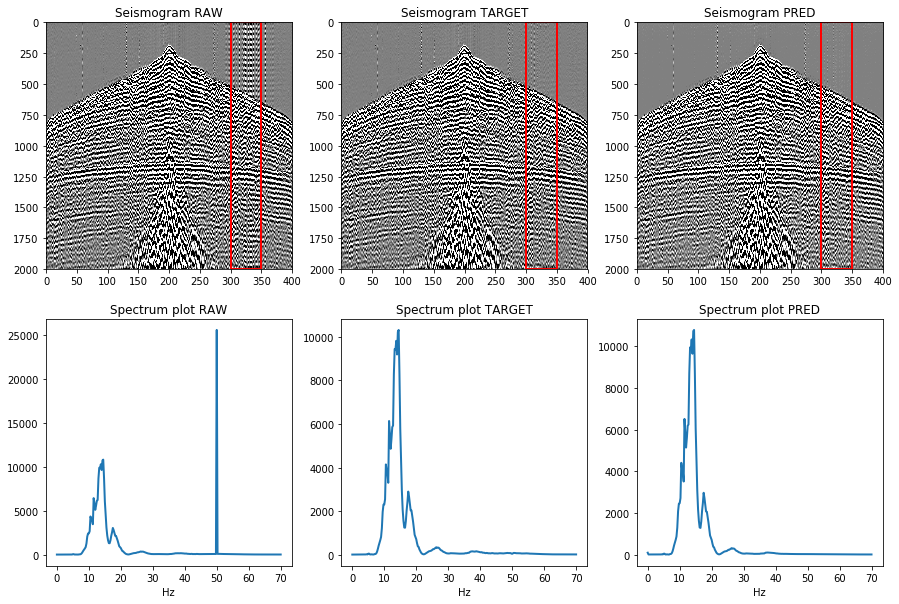

In [31]:
spectrum_plot(sgms, frame=(slice(300, 350), slice(0, 2000)), rate=0.002, max_freq=70,
              figsize=(15, 10), vmin=-0.1, vmax=0.1, cmap='gray', names=['RAW', 'TARGET', 'PRED'])

MAE metric for this field:

In [32]:
raw, lift, pred = sgms
mtr = FieldMetrics(lift, pred)
print('MAE:', mtr.mae())

MAE: 0.016271807


Correlation coefficients between target traces and model output:

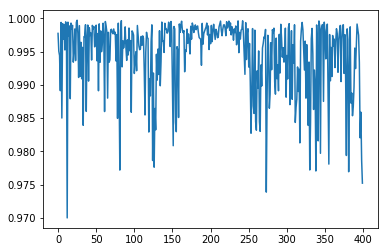

In [33]:
corr = mtr.corr_coef(reduce=None)
plt.plot(corr)
plt.show()

In [34]:
print('Averaged correlation:', mtr.corr_coef())

Averaged correlation: 0.9945033


Graph below demonstrates differences between RAW seismogram and two results of processing - human-crafted TARGET and model output PRED: 

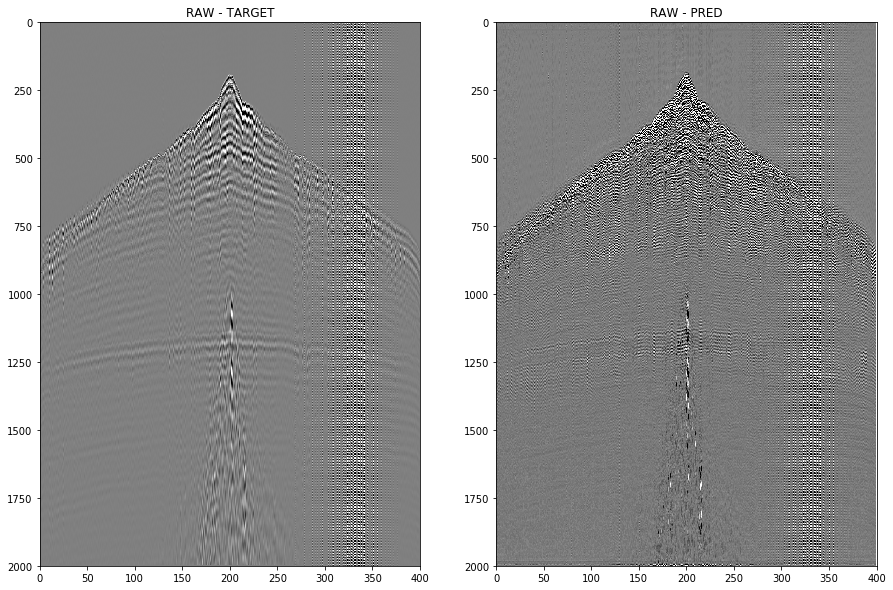

In [38]:
seismic_plot([sgms[0] - sgms[1], sgms[0] - sgms[2]], 
             figsize=(15, 10), vmin=-0.1, vmax=0.1, cmap='gray', names=['RAW - TARGET', 'RAW - PRED'])

Visualisation of a noisy trace, manually processed trace and model output. It is clear that model output lacks artefacts in the beginning and the end of the signal:

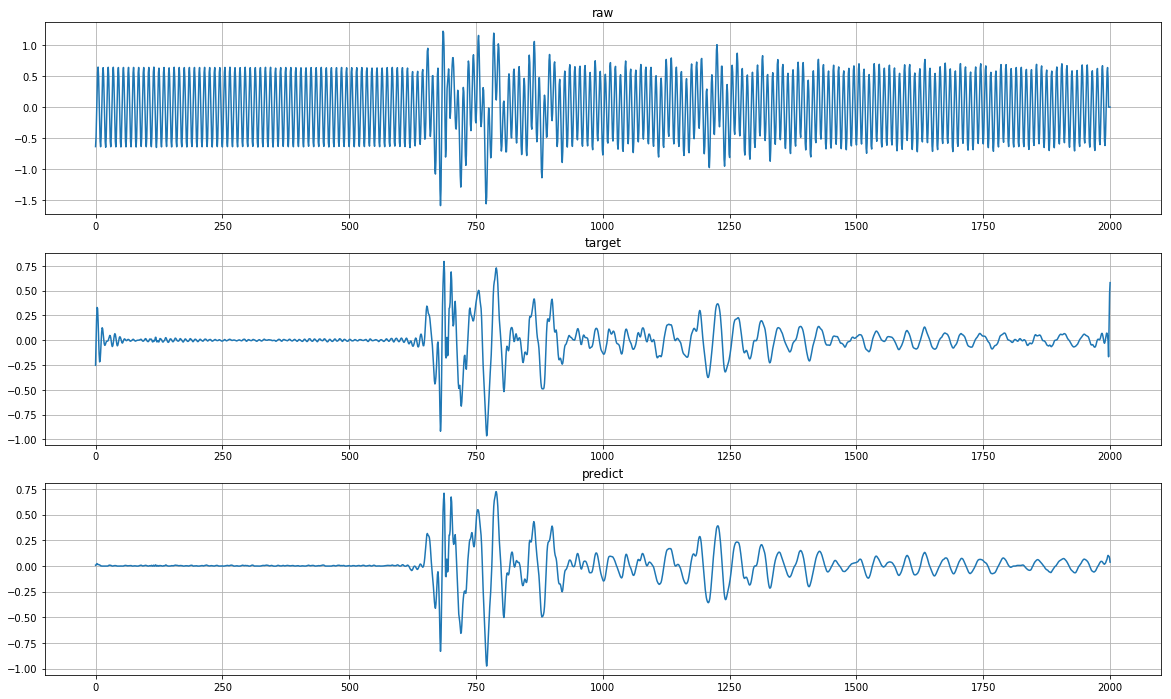

In [41]:
i = 341
data = sgms[0][i:i+1], sgms[1][i:i+1], sgms[2][i:i+1]
traces_plot(*data)

## Running time

For GTX 1080 we obtain:
* training time per one batch of size 512 traces is 2 sec.
* full model training time with batch size 512 is approx 10 hours 20 min.
* inference time per one batch of size 600 traces is 1 sec.

## Criticism

The model has two main drawbacks: 
1. While removing the noise it tends to scale the signal of both clean and noise records.
2. The model removes part of the signal from clean traces.

## Conclusion

While current model shows good results, it has a number of drawbacks. Some degree of signal modification in acceptable for noisy traces, but clean traces should  not be modified.
It is still to be investigated how stable the model is in terms of initilization and training procedure.

## Suggestions for improvements

First drawback can be easily solved via rescaling of the whole dataset. 

The second one is a bit harder. It is possible to solve this task in two stages - first perform classification for clean / noise records and then apply the model only to noisy one. But, in this case, first issue arise - the cleaned traces will be scaled, while the rest of the dataset will be not.
There are a few possible solutions: change data generation procedure, apply scaling only to the cleaned traces or train a model with awareness of the spectral component of the signal.